# Waste Classifier Improved PyTorch Model

## Goal

Improve previously attempted waste classifier `resnet50` feature extractor model by applying the following techniques:
- Increase dataset size (get more data, or better data) -> a great way to do this would be ***data augmentation*** - https://pytorch.org/vision/main/transforms.html
- Add a ***`Dropout`* layer** before the output layer - https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html
- Use ***learning rate decay*** - PyTorch learning rate scheduler - https://pytorch.org/docs/stable/optim.html

## 0 - Setup

In [1]:
import torch
import torchvision

print(torch.__version__) # 1.12+
print(torchvision.__version__) # 0.13+

import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

from scripts import data_setup, data_setup_augmented, engine, engine_lr_decay, utils, predictions
from helper_functions import download_data, set_seeds, plot_loss_curves

try:
    from scripts import data_setup, data_setup_augmented, engine, engine_lr_decay, utils, predictions
    from helper_functions import download_data, set_seeds, plot_loss_curves
    print("Base imports done.")
except:
    print("Couldn't find helper scripts, downloading from Github...")
    !git clone https://github.com/tznpau/waste-classifier
    !mv waste-classifier/scripts .
    !mv waste-classifier/helper_functions.py .
    !rm -rf waste-classifier
    from scripts import data_setup, data_setup_augmented, engine, engine_lr_decay, utils, predictions
    from helper_functions import download_data, set_seeds, plot_loss_curves

2.2.1+cu121
0.17.1+cu121
Base imports done.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1 - Getting data

In [3]:
trash_dataset_path = download_data(source="https://github.com/tznpau/waste-classifier/raw/main/data/trash_dataset.zip",
                                   destination="trash_dataset")
trash_dataset_path

[INFO] Did not find data/trash_dataset directory, creating one...
[INFO] Downloading trash_dataset.zip from https://github.com/tznpau/waste-classifier/raw/main/data/trash_dataset.zip...
[INFO] Unzipping trash_dataset.zip data...


PosixPath('data/trash_dataset')

In [4]:
# Setup training and test data directories
train_dir = trash_dataset_path / "train"
test_dir = trash_dataset_path / "test"

train_dir, test_dir

(PosixPath('data/trash_dataset/train'), PosixPath('data/trash_dataset/test'))

## 2 - ResNet50 feature extractors

https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html

In [5]:
resnet50 = torchvision.models.resnet50()
# resnet50

In [6]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

[INFO] Couldn't find torchinfo... installing it.


In [7]:
# summary(resnet50,
#         input_size=(1, 3, 224, 224),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

In [8]:
resnet50.fc

Linear(in_features=2048, out_features=1000, bias=True)

The last layer of resnet50 is called **`fc`**.

### 2.1 ResNet50 feature extractor - `v1`

In [9]:
def create_resnet50_model_v1(num_classes:int=6,
                          seed:int=42):
    weights = torchvision.models.ResNet50_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.resnet50(weights=weights).to(device)

    for param in model.parameters():
        param.requires_grad = False

    torch.manual_seed(seed)
    model.fc = nn.Linear(in_features=2048, out_features=num_classes).to(device)

    return model, transforms

In [11]:
resnet50_v1, resnet50_transforms_auto = create_resnet50_model_v1(num_classes=6, seed=42)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 167MB/s]


In [12]:
resnet50_v1.fc

Linear(in_features=2048, out_features=6, bias=True)

#### Auto created transforms

In [13]:
resnet50_transforms_auto

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

#### Dataloaders for Resnet50 `v1`

In [14]:
from scripts import data_setup

train_dataloader_resnet50, test_dataloader_resnet50, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=resnet50_transforms_auto,
                                                                                                 batch_size=32)

In [15]:
len(train_dataloader_resnet50), len(test_dataloader_resnet50), class_names

(64, 16, ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'])

### 2.2 ResNet50 augmented feature extractors - `v2` & `v3` (learning rate decay)

#### Dropout layer

Adding a `Dropout` layer after the last pooling layer `avgpool` and before the `Linear` ouput layer `fc` should introduce **regularization** and prevent overfitting.

In [16]:
def create_resnet50_model_v2(num_classes:int=6,
                          seed:int=42,
                          dropout_prob:float=0.5):
    weights = torchvision.models.ResNet50_Weights.DEFAULT
    model = torchvision.models.resnet50(weights=weights).to(device)

    for param in model.parameters():
        param.requires_grad = False

    torch.manual_seed(seed)
    model.fc = nn.Sequential(
        nn.Dropout(p=dropout_prob),
        nn.Linear(in_features=2048, out_features=num_classes)
    ).to(device)

    return model

In [17]:
resnet50_v2= create_resnet50_model_v2(num_classes=6, seed=42, dropout_prob=0.2)
resnet50_v3= create_resnet50_model_v2(num_classes=6, seed=42, dropout_prob=0.2)

In [18]:
resnet50_v2.fc

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=2048, out_features=6, bias=True)
)

#### Custom transforms ~ Data augmentation

In [19]:
resnet50_train_transform_custom = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(232, interpolation=InterpolationMode.BILINEAR),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomGrayscale(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

resnet50_test_transform_custom = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(232, interpolation=InterpolationMode.BILINEAR, antialias=True),
    transforms.CenterCrop(224),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [20]:
resnet50_train_transform_custom

Compose(
    ToTensor()
    Resize(size=232, interpolation=bilinear, max_size=None, antialias=True)
    GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))
    RandomGrayscale(p=0.1)
    RandomHorizontalFlip(p=0.5)
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [21]:
resnet50_test_transform_custom

Compose(
    ToTensor()
    Resize(size=232, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

#### Dataloaders for ResNet50 `v2` & `v3`

In [22]:
from scripts import data_setup_augmented

train_dataloader_resnet50_custom, test_dataloader_resnet50_custom, class_names = data_setup_augmented.create_dataloaders(train_dir=train_dir,
                                                                                                           test_dir=test_dir,
                                                                                                           train_transform=resnet50_train_transform_custom,
                                                                                                           test_transform=resnet50_test_transform_custom,
                                                                                                           batch_size=32)

In [23]:
len(train_dataloader_resnet50_custom), len(test_dataloader_resnet50_custom), class_names

(64, 16, ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'])

#### ResNet50 `v2` summary

In [24]:
summary(resnet50_v2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [1, 3, 224, 224]     [1, 6]               --                   Partial
├─Conv2d (conv1)                         [1, 3, 224, 224]     [1, 64, 112, 112]    (9,408)              False
├─BatchNorm2d (bn1)                      [1, 64, 112, 112]    [1, 64, 112, 112]    (128)                False
├─ReLU (relu)                            [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
├─MaxPool2d (maxpool)                    [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
├─Sequential (layer1)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   False
│    └─Bottleneck (0)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [1, 64, 56, 56]      [1, 64, 56, 56]      (4,096)              False
│    │    

All the original layers of the ResNet50 architecture have been frozen, **except** for the **output layer `fc`**.

## 3 - Training

### 3.1 ResNet `v1` training

In [25]:
from scripts import engine

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=resnet50_v1.parameters(),
                             lr=1e-3)

set_seeds(42)

resnet50_results_v1 = engine.train(model=resnet50_v1,
                                train_dataloader=train_dataloader_resnet50,
                                test_dataloader=test_dataloader_resnet50,
                                epochs=30,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 1.1582 | train_acc: 0.6240 | test_loss: 0.8186 | test_acc: 0.7868
Epoch: 2 | train_loss: 0.7156 | train_acc: 0.8001 | test_loss: 0.6476 | test_acc: 0.8379
Epoch: 3 | train_loss: 0.5769 | train_acc: 0.8338 | test_loss: 0.5543 | test_acc: 0.8474
Epoch: 4 | train_loss: 0.4690 | train_acc: 0.8745 | test_loss: 0.5164 | test_acc: 0.8571
Epoch: 5 | train_loss: 0.4163 | train_acc: 0.8960 | test_loss: 0.4674 | test_acc: 0.8750
Epoch: 6 | train_loss: 0.3737 | train_acc: 0.8981 | test_loss: 0.4305 | test_acc: 0.8811
Epoch: 7 | train_loss: 0.3394 | train_acc: 0.9126 | test_loss: 0.4205 | test_acc: 0.8823
Epoch: 8 | train_loss: 0.3118 | train_acc: 0.9123 | test_loss: 0.3961 | test_acc: 0.8901
Epoch: 9 | train_loss: 0.2875 | train_acc: 0.9284 | test_loss: 0.3883 | test_acc: 0.8956
Epoch: 10 | train_loss: 0.2632 | train_acc: 0.9377 | test_loss: 0.3650 | test_acc: 0.9060
Epoch: 11 | train_loss: 0.2458 | train_acc: 0.9429 | test_loss: 0.3628 | test_acc: 0.8937
Epoch: 12 | train_l

#### Loss & Accuracy curves ~ `v1`

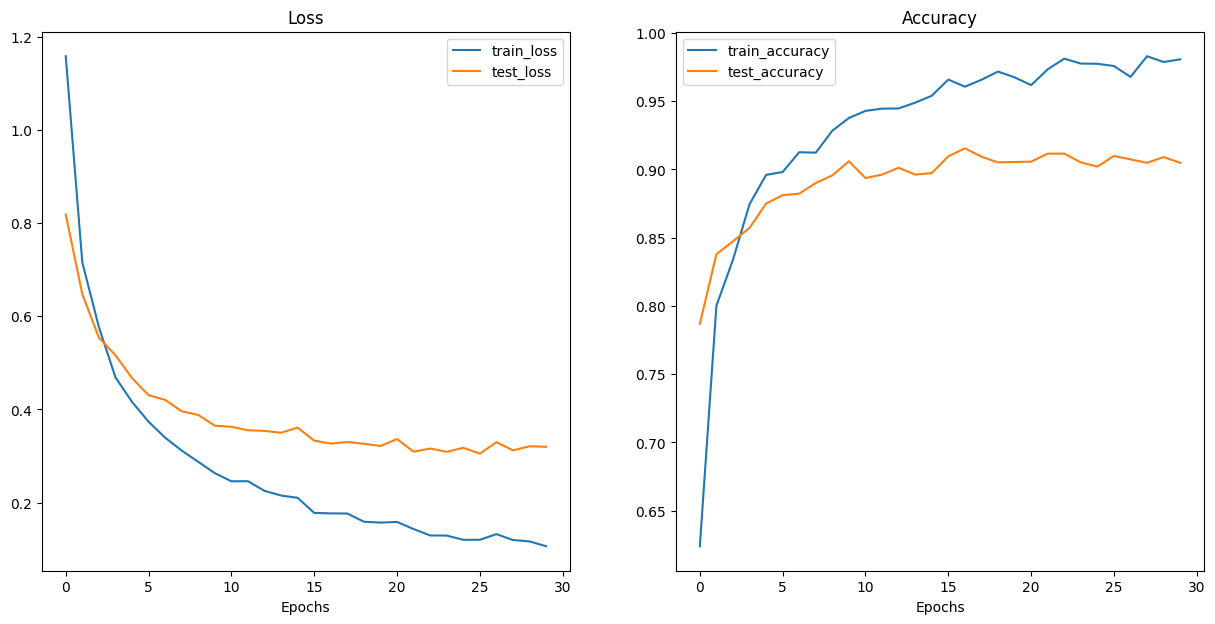

In [26]:
from helper_functions import plot_loss_curves

plot_loss_curves(resnet50_results_v1)

### 3.2 ResNet `v2` training ~ without learning rate decay

In [27]:
from scripts import engine

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=resnet50_v2.parameters(),
                             lr=1e-3)

set_seeds(42)

resnet50_results_v2 = engine.train(model=resnet50_v2,
                                train_dataloader=train_dataloader_resnet50_custom,
                                test_dataloader=test_dataloader_resnet50_custom,
                                epochs=30,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2604 | train_acc: 0.5924 | test_loss: 0.9039 | test_acc: 0.7684
Epoch: 2 | train_loss: 0.8286 | train_acc: 0.7720 | test_loss: 0.7083 | test_acc: 0.7832
Epoch: 3 | train_loss: 0.6879 | train_acc: 0.7957 | test_loss: 0.6052 | test_acc: 0.7949
Epoch: 4 | train_loss: 0.5802 | train_acc: 0.8350 | test_loss: 0.5761 | test_acc: 0.8086
Epoch: 5 | train_loss: 0.5278 | train_acc: 0.8512 | test_loss: 0.5109 | test_acc: 0.8438
Epoch: 6 | train_loss: 0.4891 | train_acc: 0.8657 | test_loss: 0.4683 | test_acc: 0.8451
Epoch: 7 | train_loss: 0.4454 | train_acc: 0.8706 | test_loss: 0.4690 | test_acc: 0.8337
Epoch: 8 | train_loss: 0.4298 | train_acc: 0.8708 | test_loss: 0.4409 | test_acc: 0.8496
Epoch: 9 | train_loss: 0.3998 | train_acc: 0.8872 | test_loss: 0.4158 | test_acc: 0.8474
Epoch: 10 | train_loss: 0.3854 | train_acc: 0.8916 | test_loss: 0.3920 | test_acc: 0.8675
Epoch: 11 | train_loss: 0.3647 | train_acc: 0.8883 | test_loss: 0.3951 | test_acc: 0.8636
Epoch: 12 | train_l

### 3.3 ResNet `v3` training ~ with learning rate decay

In [28]:
from scripts import engine_lr_decay
from torch.optim.lr_scheduler import StepLR

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=resnet50_v3.parameters(),
                             lr=0.1)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

set_seeds(42)

resnet50_results_v3 = engine_lr_decay.train(model=resnet50_v3,
                                train_dataloader=train_dataloader_resnet50_custom,
                                test_dataloader=test_dataloader_resnet50_custom,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                scheduler=scheduler,
                                epochs=30,
                                device=device)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.4783 | train_acc: 0.6963 | test_loss: 1.6375 | test_acc: 0.7773 | lr: 0.100000
Epoch: 2 | train_loss: 1.5467 | train_acc: 0.8009 | test_loss: 1.8216 | test_acc: 0.8041 | lr: 0.100000
Epoch: 3 | train_loss: 2.1704 | train_acc: 0.8001 | test_loss: 3.5686 | test_acc: 0.7812 | lr: 0.100000
Epoch: 4 | train_loss: 1.9274 | train_acc: 0.8185 | test_loss: 2.6473 | test_acc: 0.7888 | lr: 0.100000
Epoch: 5 | train_loss: 1.5868 | train_acc: 0.8564 | test_loss: 3.3031 | test_acc: 0.7916 | lr: 0.100000
Epoch: 6 | train_loss: 1.4958 | train_acc: 0.8667 | test_loss: 2.4522 | test_acc: 0.8504 | lr: 0.100000
Epoch: 7 | train_loss: 1.4362 | train_acc: 0.8739 | test_loss: 2.4853 | test_acc: 0.8181 | lr: 0.100000
Epoch: 8 | train_loss: 1.2905 | train_acc: 0.8727 | test_loss: 4.1934 | test_acc: 0.7944 | lr: 0.100000
Epoch: 9 | train_loss: 1.3876 | train_acc: 0.8791 | test_loss: 2.3691 | test_acc: 0.8672 | lr: 0.100000
Epoch: 10 | train_loss: 1.3191 | train_acc: 0.8901 | test_loss: 

#### Loss & Accuracy curves ~ `v2` & `v3`

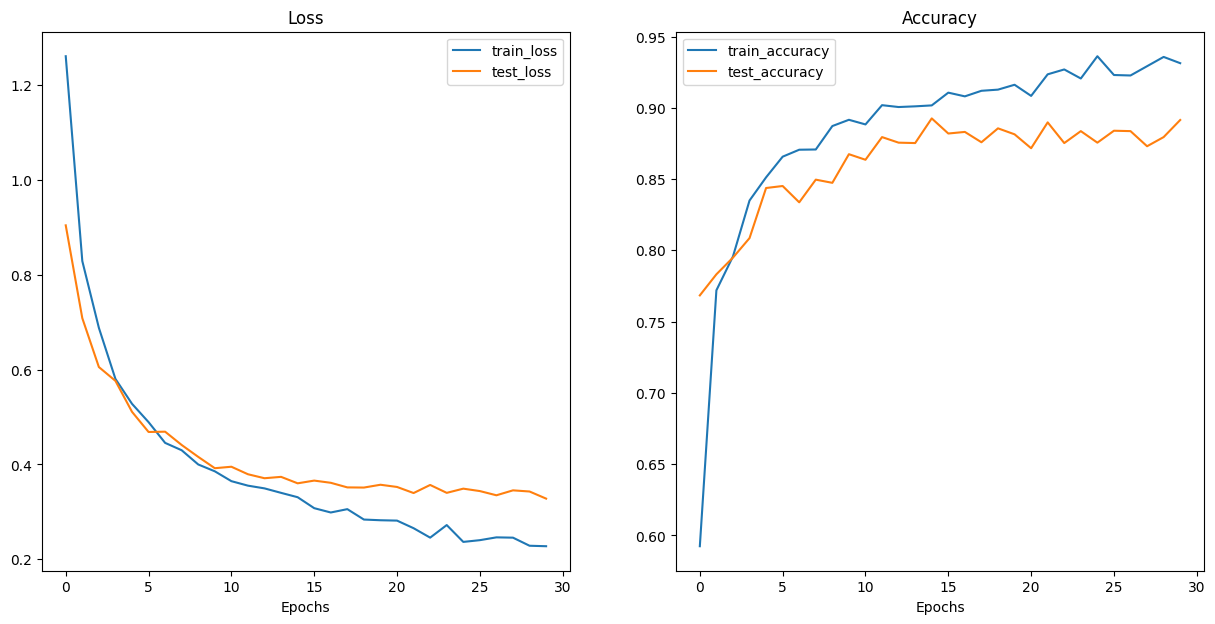

In [29]:
plot_loss_curves(resnet50_results_v2)

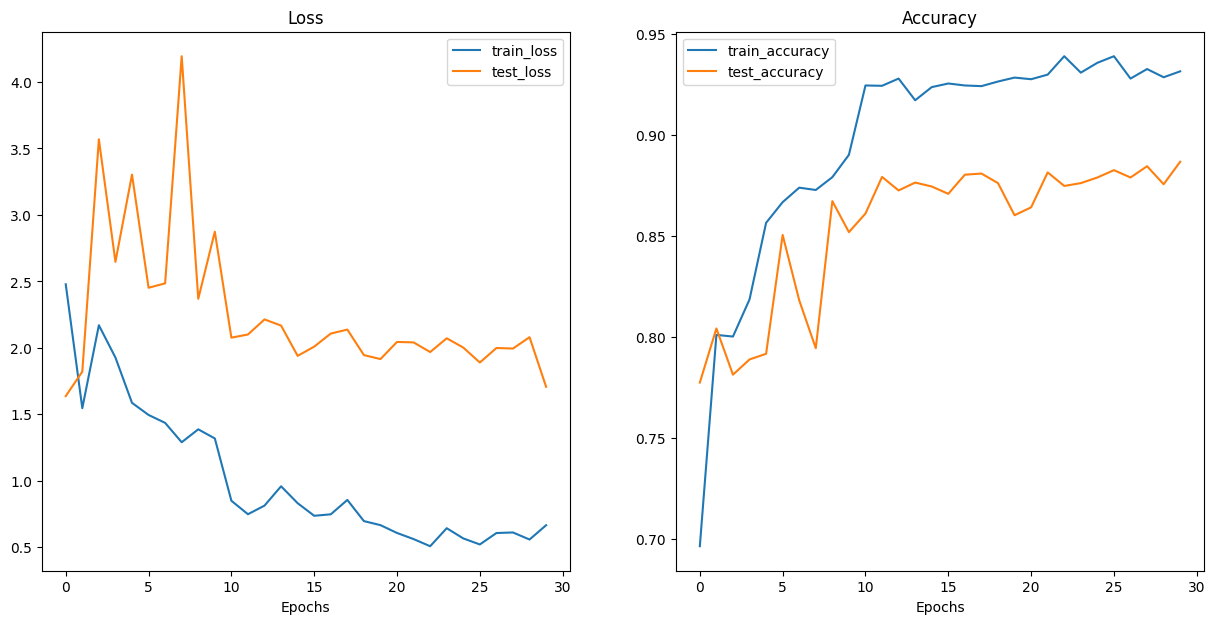

In [30]:
plot_loss_curves(resnet50_results_v3)

## 4 - Saving models & Collecting stats

In [31]:
from scripts import utils

utils.save_model(model=resnet50_v1,
                 target_dir="models",
                 model_name="resnet50_v1_model.pth")

utils.save_model(model=resnet50_v2,
                 target_dir="models",
                 model_name="resnet50_v2_model.pth")

utils.save_model(model=resnet50_v3,
                 target_dir="models",
                 model_name="resnet50_v3_model.pth")

Saving model to: models/resnet50_v1_model.pth
Saving model to: models/resnet50_v2_model.pth
Saving model to: models/resnet50_v3_model.pth


In [32]:
from pathlib import Path

size_resnet50_v1 = Path("models/resnet50_v1_model.pth").stat().st_size // (1024*1024)
size_resnet50_v2 = Path("models/resnet50_v2_model.pth").stat().st_size // (1024*1024)
size_resnet50_v3 = Path("models/resnet50_v3_model.pth").stat().st_size // (1024*1024)

In [33]:
resnet50_v1_total_params = sum(torch.numel(param) for param in resnet50_v1.parameters())
resnet50_v2_total_params = sum(torch.numel(param) for param in resnet50_v2.parameters())
resnet50_v3_total_params = sum(torch.numel(param) for param in resnet50_v3.parameters())

In [34]:
resnet50_v1_stats = {
    "test_loss" : resnet50_results_v1["test_loss"][-1],
    "test_acc" : resnet50_results_v1["test_acc"][-1],
    "total_number_of_parameters" : resnet50_v1_total_params,
    "model_size (MB)" : size_resnet50_v1
}

resnet50_v2_stats = {
    "test_loss" : resnet50_results_v2["test_loss"][-1],
    "test_acc" : resnet50_results_v2["test_acc"][-1],
    "total_number_of_parameters" : resnet50_v2_total_params,
    "model_size (MB)" : size_resnet50_v2
}

resnet50_v3_stats = {
    "test_loss" : resnet50_results_v3["test_loss"][-1],
    "test_acc" : resnet50_results_v3["test_acc"][-1],
    "total_number_of_parameters" : resnet50_v3_total_params,
    "model_size (MB)" : size_resnet50_v3
}

## 5 - Making predictions

In [55]:
from pathlib import Path

print(f"Finding all files ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

Finding all files ending with '.jpg' in directory: data/trash_dataset/test


[PosixPath('data/trash_dataset/test/trash/trash57.jpg'),
 PosixPath('data/trash_dataset/test/trash/trash93.jpg'),
 PosixPath('data/trash_dataset/test/trash/trash124.jpg'),
 PosixPath('data/trash_dataset/test/trash/trash118.jpg'),
 PosixPath('data/trash_dataset/test/trash/trash79.jpg')]

In [56]:
from scripts import predictions

resnet50_v1_predictions = predictions.pred_and_store(paths=test_data_paths,
                                                     model=resnet50_v1,
                                                     transform=resnet50_transforms_auto,
                                                     class_names=class_names,
                                                     device="cpu")

resnet50_v2_predictions = predictions.pred_and_store(paths=test_data_paths,
                                                     model=resnet50_v2,
                                                     transform=resnet50_test_transform_custom,
                                                     class_names=class_names,
                                                     device="cpu")

resnet50_v3_predictions = predictions.pred_and_store(paths=test_data_paths,
                                                     model=resnet50_v3,
                                                     transform=resnet50_test_transform_custom,
                                                     class_names=class_names,
                                                     device="cpu")

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

In [57]:
resnet50_v1_predictions[:2]

[{'image_path': PosixPath('data/trash_dataset/test/trash/trash57.jpg'),
  'class_name': 'trash',
  'pred_prob': 0.6259,
  'pred_class': 'glass',
  'time_for_pred': 0.135,
  'correct': False},
 {'image_path': PosixPath('data/trash_dataset/test/trash/trash93.jpg'),
  'class_name': 'trash',
  'pred_prob': 0.2616,
  'pred_class': 'metal',
  'time_for_pred': 0.1274,
  'correct': False}]

In [58]:
resnet50_v2_predictions[:2]

[{'image_path': PosixPath('data/trash_dataset/test/trash/trash57.jpg'),
  'class_name': 'trash',
  'pred_prob': 0.5392,
  'pred_class': 'glass',
  'time_for_pred': 0.1467,
  'correct': False},
 {'image_path': PosixPath('data/trash_dataset/test/trash/trash93.jpg'),
  'class_name': 'trash',
  'pred_prob': 0.593,
  'pred_class': 'paper',
  'time_for_pred': 0.1267,
  'correct': False}]

In [59]:
resnet50_v3_predictions[:2]

[{'image_path': PosixPath('data/trash_dataset/test/trash/trash57.jpg'),
  'class_name': 'trash',
  'pred_prob': 0.9995,
  'pred_class': 'glass',
  'time_for_pred': 0.1522,
  'correct': False},
 {'image_path': PosixPath('data/trash_dataset/test/trash/trash93.jpg'),
  'class_name': 'trash',
  'pred_prob': 1.0,
  'pred_class': 'paper',
  'time_for_pred': 0.139,
  'correct': False}]

In [60]:
import pandas as pd
resnet50_v1_predictions_df = pd.DataFrame(resnet50_v1_predictions)
resnet50_v2_predictions_df = pd.DataFrame(resnet50_v2_predictions)
resnet50_v3_predictions_df = pd.DataFrame(resnet50_v3_predictions)

#### resnet `v1`

In [61]:
resnet50_v1_predictions_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/trash_dataset/test/trash/trash57.jpg,trash,0.6259,glass,0.1350,False
1,data/trash_dataset/test/trash/trash93.jpg,trash,0.2616,metal,0.1274,False
2,data/trash_dataset/test/trash/trash124.jpg,trash,0.3646,plastic,0.1229,False
3,data/trash_dataset/test/trash/trash118.jpg,trash,0.8948,trash,0.1333,True
4,data/trash_dataset/test/trash/trash79.jpg,trash,0.9686,trash,0.1305,True


In [62]:
resnet50_v1_predictions_df.correct.value_counts()

correct
True     461
False     47
Name: count, dtype: int64

In [63]:
resnet50_v1_average_time_per_pred = round(resnet50_v1_predictions_df.time_for_pred.mean(), 4)
print(f"Average time per prediction: {resnet50_v1_average_time_per_pred} seconds")

Average time per prediction: 0.1402 seconds


In [64]:
resnet50_v1_stats["time_per_pred_cpu"] = resnet50_v1_average_time_per_pred

#### resnet `v2`

In [65]:
resnet50_v2_predictions_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/trash_dataset/test/trash/trash57.jpg,trash,0.5392,glass,0.1467,False
1,data/trash_dataset/test/trash/trash93.jpg,trash,0.5930,paper,0.1267,False
2,data/trash_dataset/test/trash/trash124.jpg,trash,0.7953,plastic,0.1232,False
3,data/trash_dataset/test/trash/trash118.jpg,trash,0.6267,trash,0.1339,True
4,data/trash_dataset/test/trash/trash79.jpg,trash,0.5498,trash,0.1270,True


In [66]:
resnet50_v2_predictions_df.correct.value_counts()

correct
True     454
False     54
Name: count, dtype: int64

In [67]:
resnet50_v2_average_time_per_pred = round(resnet50_v2_predictions_df.time_for_pred.mean(), 4)
print(f"Average time per prediction: {resnet50_v2_average_time_per_pred} seconds")

Average time per prediction: 0.137 seconds


In [68]:
resnet50_v2_stats["time_per_pred_cpu"] = resnet50_v2_average_time_per_pred

#### resnet `v3`

In [69]:
resnet50_v3_predictions_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/trash_dataset/test/trash/trash57.jpg,trash,0.9995,glass,0.1522,False
1,data/trash_dataset/test/trash/trash93.jpg,trash,1.0000,paper,0.1390,False
2,data/trash_dataset/test/trash/trash124.jpg,trash,0.9999,plastic,0.1346,False
3,data/trash_dataset/test/trash/trash118.jpg,trash,1.0000,trash,0.1340,True
4,data/trash_dataset/test/trash/trash79.jpg,trash,0.9975,trash,0.1327,True


In [70]:
resnet50_v3_predictions_df.correct.value_counts()

correct
True     451
False     57
Name: count, dtype: int64

In [71]:
resnet50_v3_average_time_per_pred = round(resnet50_v3_predictions_df.time_for_pred.mean(), 4)
print(f"Average time per prediction: {resnet50_v3_average_time_per_pred} seconds")

Average time per prediction: 0.1381 seconds


In [72]:
resnet50_v3_stats["time_per_pred_cpu"] = resnet50_v3_average_time_per_pred

## 6 - Comparing results

In [73]:
df = pd.DataFrame([resnet50_v1_stats, resnet50_v2_stats, resnet50_v3_stats])
df["model"] = ["resnet50_v1", "resnet50_v2", "resnet50_v3"]
df["test_acc"] = round(df["test_acc"] * 100, 2)
df

,test_loss,test_acc,total_number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.319805,90.49,23520326,90,0.1402,resnet50_v1
1,0.327882,89.15,23520326,90,0.1370,resnet50_v2
2,1.707327,88.67,23520326,90,0.1381,resnet50_v3


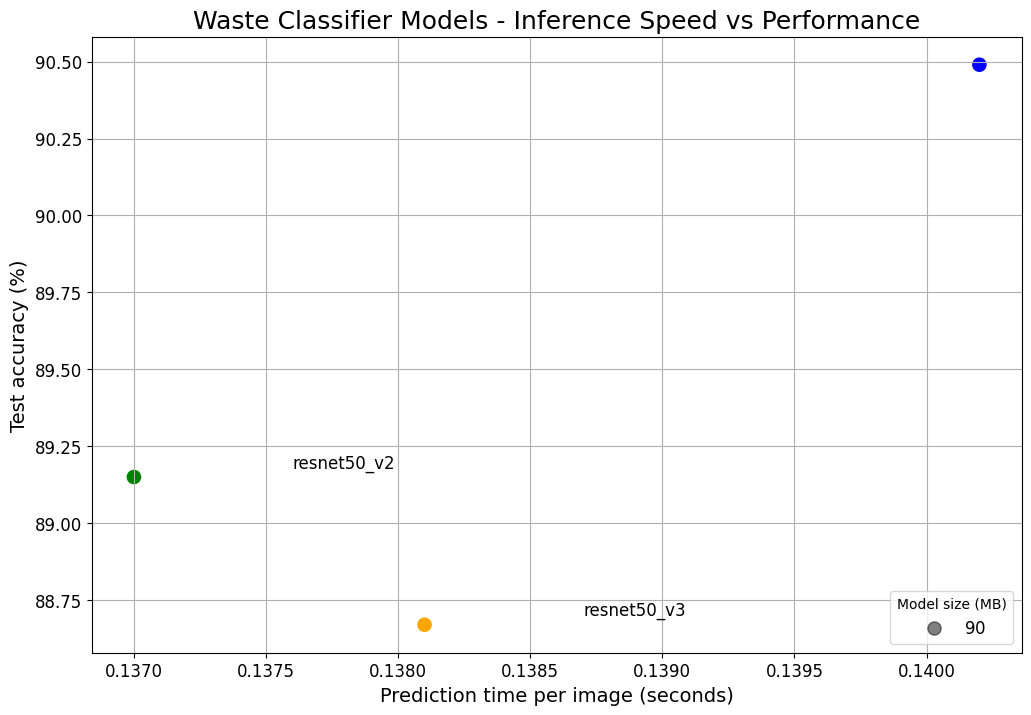

In [74]:
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "green", "orange"],
                     s="model_size (MB)") # size the dots by the model sizes

ax.set_title("Waste Classifier Models - Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

for index, row in df.iterrows():
    ax.annotate(text=row["model"],
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
                size=12)

handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc="lower right",
                              title="Model size (MB)",
                              fontsize=12)

plt.savefig("resnet50-versions-inference-speed-vs-performance.jpg")
plt.show()